# Classification Walkthrough: Titanic Dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import (
    ensemble,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)
from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC,
)
from yellowbrick.model_selection import (
    LearningCurve,
)
%matplotlib inline

In [2]:
# url = (
#     "http://biostat.mc.vanderbilt.edu/"
#     "wiki/pub/Main/DataSets/titanic3.xls"
# )
df = pd.read_excel("titanic3.xls")
orig_df = df

In [3]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [4]:
import ydata_profiling
ydata_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df.shape

(1309, 14)

In [6]:
df.describe().iloc[:, :2]

,pclass,survived
count,1309.000000,1309.000000
mean,2.294882,0.381971
std,0.837836,0.486055
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,3.000000,1.000000
max,3.000000,1.000000


In [7]:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [8]:
df.isnull().sum(axis=1).loc[:10]

0     1
1     1
2     2
3     1
4     2
5     1
6     1
7     2
8     1
9     2
10    1
dtype: int64

In [9]:
mask = df.isnull().any(axis=1)

In [10]:
mask.head()  # rows

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [11]:
df[mask].body.head()

0      NaN
1      NaN
2      NaN
3    135.0
4      NaN
Name: body, dtype: float64

In [12]:
df.sex.value_counts(dropna=False)

male      843
female    466
Name: sex, dtype: int64

In [13]:
df.embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

In [14]:
name = df.name
name.head(3)

0     Allen, Miss. Elisabeth Walton
1    Allison, Master. Hudson Trevor
2      Allison, Miss. Helen Loraine
Name: name, dtype: object

In [15]:
df = df.drop(
    columns=[
        "name",
        "ticket",
        "home.dest",
        "boat",
        "body",
        "cabin",
    ]
)

In [16]:
df = pd.get_dummies(df)

In [17]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [18]:
df = df.drop(columns="sex_male")

In [19]:
df = pd.get_dummies(df, drop_first=True)

In [20]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [21]:
y = df.survived
X = df.drop(columns="survived")

In [22]:
# import janitor as jn
# X, y = jn.get_features_targets(
#     df, target_columns="survived"
# )

In [23]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [24]:
X.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'embarked_C',
       'embarked_Q', 'embarked_S'],
      dtype='object')

In [25]:
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import impute
num_cols = [
    "pclass",
    "age",
    "sibsp",
    "parch",
    "fare",
    "sex_female",
]

In [26]:
imputer = impute.IterativeImputer()
imputed = imputer.fit_transform(
    X_train[num_cols]
)
X_train[num_cols] = imputed
imputed = imputer.transform(X_test[num_cols])
X_test[num_cols] = imputed

In [27]:
meds = X_train.median()
X_train = X_train.fillna(meds)
X_test = X_test.fillna(meds)

In [28]:
cols = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'embarked_C',
   'embarked_Q', 'embarked_S']
sca = preprocessing.StandardScaler()
X_train = sca.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=cols)
X_test = sca.transform(X_test)
X_test = pd.DataFrame(X_test, columns=cols)

In [29]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

In [30]:
def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

In [31]:
ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

In [32]:
from sklearn.dummy import DummyClassifier
bm = DummyClassifier()
bm.fit(X_train, y_train)
bm.score(X_test, y_test)  # accuracy

0.5699745547073791

In [33]:
from sklearn import metrics
metrics.precision_score(
    y_test, bm.predict(X_test)
)

/home/nglazov@pak-cspmz.ru/.virtualenvs/r-tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [34]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import (
    LogisticRegression,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import (
    KNeighborsClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
)
import xgboost

In [35]:
for model in [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier,
]:
    cls = model()
    kfold = model_selection.KFold(
        n_splits=10, random_state=42, shuffle=True
    )
    s = model_selection.cross_val_score(
        cls, X, y, scoring="roc_auc", cv=kfold
    )
    print(
        f"{model.__name__:22}  AUC: "
        f"{s.mean():.3f} STD: {s.std():.2f}"
    )

DummyClassifier         AUC: 0.500 STD: 0.00
LogisticRegression      AUC: 0.840 STD: 0.04
DecisionTreeClassifier  AUC: 0.765 STD: 0.02
KNeighborsClassifier    AUC: 0.829 STD: 0.02
GaussianNB              AUC: 0.811 STD: 0.05
SVC                     AUC: 0.838 STD: 0.03
RandomForestClassifier  AUC: 0.846 STD: 0.02
XGBClassifier           AUC: 0.852 STD: 0.02


In [36]:
from mlxtend.classifier import (
    StackingClassifier,
)
clfs = [
    x()
    for x in [
        LogisticRegression,
        DecisionTreeClassifier,
        KNeighborsClassifier,
        GaussianNB,
        SVC,
        RandomForestClassifier,
    ]
]
stack = StackingClassifier(
    classifiers=clfs,
    meta_classifier=LogisticRegression(),
)
kfold = model_selection.KFold(
    n_splits=10, random_state=42, shuffle=True
)
s = model_selection.cross_val_score(
    stack, X, y, scoring="roc_auc", cv=kfold
)
print(
    f"{stack.__class__.__name__}  "
    f"AUC: {s.mean():.3f}  STD: {s.std():.2f}"
)

StackingClassifier  AUC: 0.791  STD: 0.04


In [37]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100, random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
rf.score(X_test, y_test)

0.7837150127226463

In [39]:
metrics.precision_score(
    y_test, rf.predict(X_test)
)

0.7916666666666666

In [40]:
for col, val in sorted(
    zip(
        X_train.columns,
        rf.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

age            0.285
fare           0.262
sex_male       0.241
pclass         0.089
sibsp          0.050


In [41]:
rf4 = ensemble.RandomForestClassifier()
params = {
    "max_features": [0.4, "sqrt"],
    "n_estimators": [15, 200],
    "min_samples_leaf": [1, 0.1],
    "random_state": [42],
}
cv = model_selection.GridSearchCV(
    rf4, params, n_jobs=-1
).fit(X_train, y_train)
print(cv.best_params_)

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42}


In [42]:
rf5 = ensemble.RandomForestClassifier(
    **{
        "max_features": "sqrt",
        "min_samples_leaf": 0.1,
        "n_estimators": 200,
        "random_state": 42,
    }
)
rf5.fit(X_train, y_train)
rf5.score(X_test, y_test)

0.7073791348600509

In [43]:
from sklearn.metrics import confusion_matrix
y_pred = rf5.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[217,   7],
       [108,  61]])

/home/nglazov@pak-cspmz.ru/.virtualenvs/r-tensorflow/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


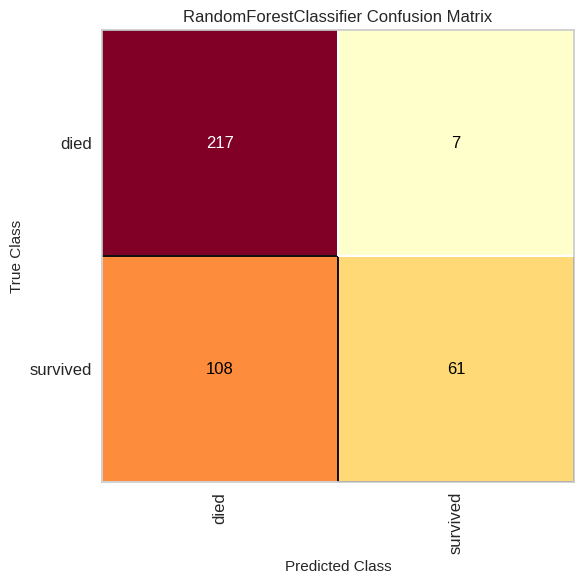

<AxesSubplot: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [44]:
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    rf5,
    classes=["died", "survived"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.poof()

In [45]:
y_pred = rf5.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6648483727810651

/home/nglazov@pak-cspmz.ru/.virtualenvs/r-tensorflow/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


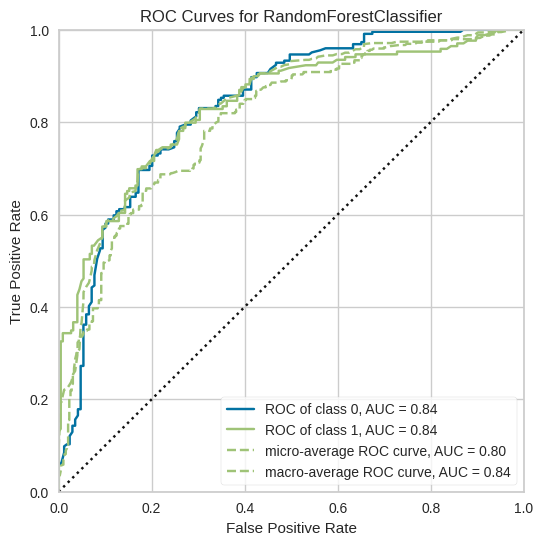

<AxesSubplot: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(rf5)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)
roc_viz.poof()
#fig.savefig("images/mlpr_0305.png")

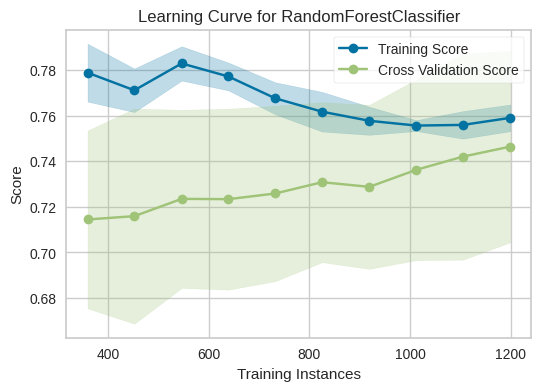

<AxesSubplot: title={'center': 'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

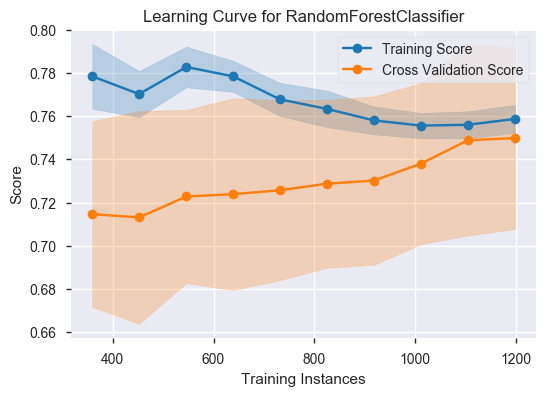

In [47]:
import numpy as np
fig, ax = plt.subplots(figsize=(6, 4))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(
    rf5,
    cv=cv,
    train_sizes=sizes,
    scoring="f1_weighted",
    n_jobs=4,
    ax=ax,
)
lc_viz.fit(X, y)
lc_viz.poof()

In [48]:
import pickle
pic = pickle.dumps(rf5)
rf6 = pickle.loads(pic)
y_pred = rf6.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6648483727810651